In [2007]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [2008]:
#!pip install tqdm

In [2009]:
#df0 = pd.read_csv('../spreadsheets/rlhf_20250104_6.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # Best
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv')

In [2010]:
#df0['action'] = df0['action'].replace('go_long', 'do_nothing')

In [2011]:
df0.columns

Index(['Unnamed: 0', 'open', 'high', 'ema-26', 'ema-12', 'low',
       'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk',
       'short_kdj', 'sma-05', 'sma-07', 'sma-compare', 'is_short', 'action',
       'imit-action', 'nlpreds', 'reward'],
      dtype='object')

In [2012]:
df0.head()

,Unnamed: 0,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,short_kdj,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward
0,0,0.005390,0.005390,0.005428,0.005435,0.005330,1,0.005330,5.353044e+07,0.005462,0,0,0.005406,0.005423,1,1,do_nothing,go_long,do_nothing,-5.832726
1,1,610.150000,613.170000,609.297695,607.802032,609.100000,0,612.450000,1.994136e+04,607.673600,0,0,609.482000,609.415714,0,0,do_nothing,go_short,do_nothing,-6.664651
2,2,16.152000,16.212000,15.870445,15.766896,15.921000,1,15.927000,6.082260e+04,15.751240,0,0,15.920600,15.865571,0,0,do_nothing,go_short,do_nothing,-13.810239
3,3,0.001823,0.001841,0.001819,0.001819,0.001819,0,0.001835,1.825455e+08,0.001823,0,0,0.001819,0.001817,0,1,do_nothing,go_long,do_nothing,-2.662213
4,4,2.210000,2.220000,2.179647,2.175725,2.175000,1,2.182000,2.794219e+05,2.143880,0,0,2.207800,2.198714,0,0,do_nothing,go_short,do_nothing,-0.998845


In [2013]:
df0.drop(['Unnamed: 0'], axis=1, inplace=True)

In [2014]:
df0['action'].value_counts()

action
go_short      5268
go_long       3612
do_nothing     714
Name: count, dtype: int64

In [2015]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [2016]:
train_data = df0 #prep_data(df0)

In [2017]:
train_data.head(2)

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,short_kdj,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward
0,0.00539,0.00539,0.005428,0.005435,0.00533,1,0.00533,53530437.00,0.005462,0,0,0.005406,0.005423,1,1,do_nothing,go_long,do_nothing,-5.832726
1,610.15000,613.17000,609.297695,607.802032,609.10000,0,612.45000,19941.36,607.673600,0,0,609.482000,609.415714,0,0,do_nothing,go_short,do_nothing,-6.664651


In [2018]:
new_cols = ['open', 'high', 'ema-26', 'ema-12', 'low', \
            'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk', 'short_kdj', \
            'sma-compare', 'is_short'
        ]

In [2019]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
train_data["action_num"] = train_data["action"].map(action_mapping)

In [2020]:
# Define RL parameters
#states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
states = train_data[new_cols].values
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [2021]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [2022]:
# Hyperparameters [0.25, 0.95, 1.0, 0.99, 0.99, 10000], [0.9, 0.95, 1.0, 0.99, 0.99, 8000], [0.7, 0.75, 1.0, 0.97, 0.999, 28000]
# [0.05, 0.95, 1.0, 0.999, 0.995, 12000], [0.25, 0.95, 1.0, 0.99, 0.99, 10000], [1, 0.95, 0.1, 0.96, 0.96, 12000], [0.25, 0.99, 0.01, 0.997, 0.99, 8000]
# [1, 0.75, 0.05, 0.999, 0.999, 10000]
'''
alpha = 1
gamma = 0.95
epsilon = 0.1
min_epsilon = 0.96
decay_rate = 0.96
n_episodes = 12000
'''
alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = 1, 0.75, 0.05, 0.999, 0.999, 10000



In [2023]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('large_state_to_index.npy', state_to_index)


In [2024]:
# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action

evaluating results per episode ...:   0%|          | 8/10000 [00:00<04:43, 35.27it/s]

Episode 0/10000 - Total Reward: -13152.411804410016, Epsilon: 0.999


evaluating results per episode ...:   4%|▍         | 404/10000 [00:12<05:25, 29.51it/s]

Episode 400/10000 - Total Reward: -9445.539043419994, Epsilon: 0.999


evaluating results per episode ...:   8%|▊         | 812/10000 [00:26<04:55, 31.07it/s]

Episode 800/10000 - Total Reward: -15456.930702130006, Epsilon: 0.999


evaluating results per episode ...:  12%|█▏        | 1211/10000 [00:39<03:46, 38.84it/s]

Episode 1200/10000 - Total Reward: -11286.576064900011, Epsilon: 0.999


evaluating results per episode ...:  16%|█▌        | 1606/10000 [00:53<04:29, 31.12it/s]

Episode 1600/10000 - Total Reward: -15217.630601000006, Epsilon: 0.999


evaluating results per episode ...:  20%|██        | 2006/10000 [01:06<04:40, 28.55it/s]

Episode 2000/10000 - Total Reward: 184.15408879995633, Epsilon: 0.999


evaluating results per episode ...:  24%|██▍       | 2407/10000 [01:18<04:25, 28.62it/s]

Episode 2400/10000 - Total Reward: -14636.562699530004, Epsilon: 0.999


evaluating results per episode ...:  28%|██▊       | 2807/10000 [01:31<04:01, 29.76it/s]

Episode 2800/10000 - Total Reward: -8872.230408669988, Epsilon: 0.999


evaluating results per episode ...:  32%|███▏      | 3205/10000 [01:45<03:44, 30.26it/s]

Episode 3200/10000 - Total Reward: -5269.451602870015, Epsilon: 0.999


evaluating results per episode ...:  36%|███▌      | 3611/10000 [01:59<03:41, 28.85it/s]

Episode 3600/10000 - Total Reward: -4599.220527180003, Epsilon: 0.999


evaluating results per episode ...:  40%|████      | 4004/10000 [02:12<03:18, 30.28it/s]

Episode 4000/10000 - Total Reward: -6111.61572032, Epsilon: 0.999


evaluating results per episode ...:  44%|████▍     | 4405/10000 [02:26<03:15, 28.69it/s]

Episode 4400/10000 - Total Reward: -8566.761060359986, Epsilon: 0.999


evaluating results per episode ...:  48%|████▊     | 4805/10000 [02:39<02:08, 40.28it/s]

Episode 4800/10000 - Total Reward: -15070.551458660006, Epsilon: 0.999


evaluating results per episode ...:  52%|█████▏    | 5205/10000 [02:52<03:05, 25.87it/s]

Episode 5200/10000 - Total Reward: -187.9111289000484, Epsilon: 0.999


evaluating results per episode ...:  56%|█████▌    | 5607/10000 [03:07<02:30, 29.20it/s]

Episode 5600/10000 - Total Reward: -643.0905597600653, Epsilon: 0.999


evaluating results per episode ...:  60%|██████    | 6004/10000 [03:20<02:28, 26.95it/s]

Episode 6000/10000 - Total Reward: -8131.041227899976, Epsilon: 0.999


evaluating results per episode ...:  64%|██████▍   | 6406/10000 [03:32<01:59, 29.96it/s]

Episode 6400/10000 - Total Reward: -2448.3520462800548, Epsilon: 0.999


evaluating results per episode ...:  68%|██████▊   | 6809/10000 [03:46<01:27, 36.46it/s]

Episode 6800/10000 - Total Reward: -8888.06921188999, Epsilon: 0.999


evaluating results per episode ...:  72%|███████▏  | 7208/10000 [03:59<01:35, 29.27it/s]

Episode 7200/10000 - Total Reward: -12404.345486610013, Epsilon: 0.999


evaluating results per episode ...:  76%|███████▌  | 7605/10000 [04:13<01:20, 29.66it/s]

Episode 7600/10000 - Total Reward: -14191.661703490006, Epsilon: 0.999


evaluating results per episode ...:  80%|████████  | 8003/10000 [04:26<01:04, 31.04it/s]

Episode 8000/10000 - Total Reward: -4214.839710450057, Epsilon: 0.999


evaluating results per episode ...:  84%|████████▍ | 8410/10000 [04:41<00:58, 26.97it/s]

Episode 8400/10000 - Total Reward: -8577.047026599987, Epsilon: 0.999


evaluating results per episode ...:  88%|████████▊ | 8809/10000 [04:55<00:43, 27.30it/s]

Episode 8800/10000 - Total Reward: -8878.236471879989, Epsilon: 0.999


evaluating results per episode ...:  92%|█████████▏| 9204/10000 [05:07<00:22, 36.14it/s]

Episode 9200/10000 - Total Reward: -10927.528291990016, Epsilon: 0.999


evaluating results per episode ...:  96%|█████████▌| 9604/10000 [05:20<00:12, 31.26it/s]

Episode 9600/10000 - Total Reward: -4464.820300570047, Epsilon: 0.999


evaluating results per episode ...: 100%|██████████| 10000/10000 [05:33<00:00, 29.96it/s]


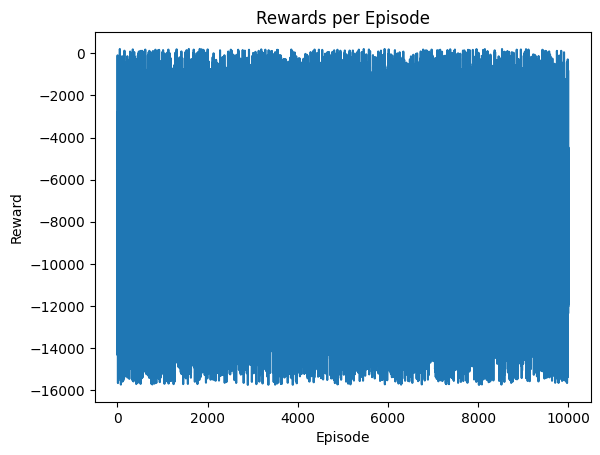

In [2025]:

# Set random seed for reproducibility and train the loop
np.random.seed(42)
random.seed(42)
# Initialize a list to store rewards per episode
rewards_per_episode = []

for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 400 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("large_q_table.npy", q_table)

# Example: Plotting the rewards
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()



In [2026]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

In [2027]:
#state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
#                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
#                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])

def prep_state(
                open: float, high: float, ema_26: float, ema_12: float, low: float,
                mean_grad_hist: float, close: float, volume: float, sma_25: float,
                long_jcrosk: float, short_kdj: float, sma_compare: int, is_short: int,
            ):
    state = np.array([[open, high, ema_26, ema_12, low, mean_grad_hist, close, volume, sma_25, long_jcrosk, short_kdj, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state


In [2028]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = loaded_state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action

In [2029]:
# Example usage
q_table = load_q_table("large_q_table.npy")
state_to_index = load_state_index_mapping("large_state_to_index.npy")

# Predict actions for each row in the DataFrame
for idx, row in train_data.iterrows():
    state = row[new_cols].values.reshape(1, -1)
    try:
        action = predict_action(state, q_table, state_to_index, action_mapping)
        train_data.loc[idx, "predicted_action"] = action
    except ValueError as e:
        print(e)
        train_data.loc[idx, "predicted_action"] = "unknown"

# Display the first 15 rows with predicted actions
#train_data.head(15)

In [2030]:
train_data.tail(15)

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,action_num,predicted_action
9579,3.599000,3.634000,3.650141,3.759703,3.072000,1,3.208000,5.339710e+06,3.773440,0,...,3.557000,3.625429,1,1,do_nothing,go_short,do_nothing,-10.398551,2,go_long
9580,403.740000,405.360000,408.777427,415.122224,400.000000,1,400.270000,7.090600e+03,417.680400,0,...,404.728000,405.378571,1,0,do_nothing,go_short,do_nothing,-22.285516,2,go_long
9581,332.450000,332.780000,329.352335,327.166878,331.230000,0,331.760000,2.270751e+04,327.236000,0,...,330.558000,330.138571,0,0,do_nothing,go_short,do_nothing,-7.784396,2,go_long
9582,40276.600000,40342.100000,39524.841593,39145.907667,39987.600000,1,40084.400000,3.264500e+01,38876.520000,0,...,39915.080000,39890.171429,0,0,do_nothing,go_short,do_nothing,-8.222254,2,go_long
9583,1.827800,1.863600,1.875951,1.916730,1.822500,0,1.861800,5.597561e+05,1.920500,0,...,1.859500,1.864043,1,1,do_nothing,go_short,do_nothing,-16.994467,2,go_long
9584,0.198100,0.199700,0.206379,0.209592,0.196900,1,0.199600,8.328819e+05,0.210928,0,...,0.204320,0.205586,1,1,do_nothing,go_short,do_nothing,-4.582991,2,go_long
9585,77.960000,81.730000,80.344431,82.214751,75.640000,0,81.430000,3.909254e+04,82.741600,0,...,76.922000,78.862857,1,0,do_nothing,go_short,do_nothing,-21.362207,2,go_long
9586,0.345900,0.346000,0.352661,0.358333,0.342300,0,0.343100,3.660012e+05,0.359624,0,...,0.348220,0.349329,1,1,do_nothing,go_short,do_nothing,-10.956925,2,go_long
9587,0.409400,0.430400,0.470327,0.500979,0.352300,1,0.392500,3.056824e+08,0.510720,0,...,0.436640,0.460586,1,1,do_nothing,go_short,do_nothing,-12.173111,2,go_long
9588,184.420000,184.420000,186.936727,188.752732,182.000000,0,183.090000,3.327910e+04,190.875600,1,...,184.684000,185.420000,1,0,do_nothing,go_short,do_nothing,-14.726109,2,go_long


In [2031]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       9552
go_short        24
do_nothing      18
Name: count, dtype: int64

In [2052]:
m = train_data[(train_data['predicted_action'] != 'go_long') & (train_data['reward'] < 0)]

In [2053]:
m['is_short'].value_counts()

is_short
1    6
0    2
Name: count, dtype: int64

In [2034]:
longs = dict(m['is_short'].value_counts().items()).get(0)
print(longs)
shorts = dict(m['is_short'].value_counts().items()).get(1)
print(shorts)

3579
5267


In [2035]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)
print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/9593
Current Predicted Reward: 0
Current Actual Reward: -6.66465099
Processed state 100/9593
Current Predicted Reward: 37.98101842999999
Current Actual Reward: -44.83376707
Processed state 200/9593
Current Predicted Reward: 195.54380049000002
Current Actual Reward: 112.72901499
Processed state 300/9593
Current Predicted Reward: 327.16696533000015
Current Actual Reward: 244.3521798299999
Processed state 400/9593
Current Predicted Reward: 503.1988167800002
Current Actual Reward: 420.3840312799999
Processed state 500/9593
Current Predicted Reward: 644.8830566299998
Current Actual Reward: 562.0682711299996
Processed state 600/9593
Current Predicted Reward: 770.6609891399995
Current Actual Reward: 687.8462036399993
Processed state 700/9593
Current Predicted Reward: 895.8091466399995
Current Actual Reward: 812.9943611399993
Processed state 800/9593
Current Predicted Reward: 1030.17423409
Current Actual Reward: 947.3594485899997
Processed state 900/9593
Current Predicted Rew

In [2036]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 37.35%


In [2037]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[3579   20   13]
 [5267    0    1]
 [ 706    4    4]]


In [2038]:
df0['action'].value_counts()

action
go_short      5268
go_long       3612
do_nothing     714
Name: count, dtype: int64

In [2063]:
m = train_data[(train_data['predicted_action'] != 'go_short') & (train_data['reward'] > 0)]

In [2064]:
m['is_short'].value_counts()

is_short
1    5268
0    3592
Name: count, dtype: int64

In [2041]:
m[m['sma-compare'] == 0].head()

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,action_num,predicted_action
3,0.001823,0.001841,0.001819,0.001819,0.001819,0,0.001835,1.825455e+08,0.001823,0,...,0.001819,0.001817,0,1,do_nothing,go_long,do_nothing,-2.662213,2,go_short
8,76.000000,76.050000,75.613100,74.875592,75.640000,1,75.710000,2.928498e+04,74.796000,0,...,76.022000,76.044286,0,0,do_nothing,go_short,do_nothing,-10.590822,2,go_short


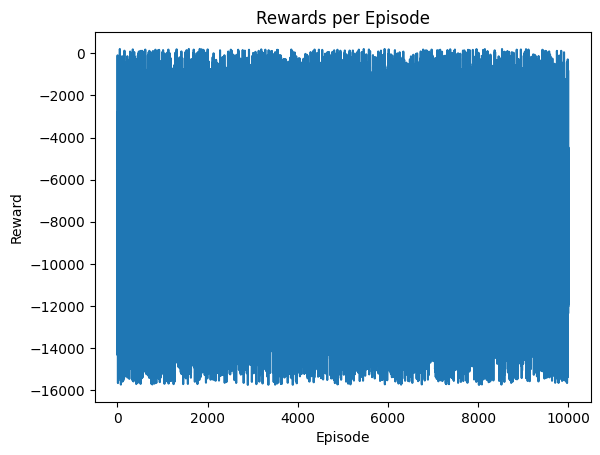

In [2042]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [2043]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate) # default min_epsilon = 0.01

    return q_table, rewards_per_episode


In [2044]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    # Add tqdm for progress visualization
    for state_index in tqdm(range(n_states), desc="Evaluating States"):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [2045]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

'''

'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [2046]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [2047]:
'''
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000]
}

# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > best_cumulative_pred_reward:\n            best_cumulative_pred_reward = cumulative_pred_reward\n        